In [1]:
import os
import pandas as pd
from scipy.stats import pearsonr, spearmanr, kendalltau
from pathlib import Path
from scipy.stats import f_oneway, ttest_ind
import scipy.stats as stats


file_path = Path(os.getcwd()).parent / 'data/summarization_evaluation_metrics.csv'

existing_df = pd.read_csv(
    file_path, 
    sep='\t',
    quoting=1,
    quotechar='"',
    escapechar='\\',
    doublequote=True,
    engine='python',
)

final_df = existing_df.copy()

final_df['ROUGE-AVG'] = final_df[['rouge-1_f', 'rouge-2_f', 'rouge-l_f']].mean(axis=1)

metrics = ['bert_f1', 'meteor']

for metric in metrics:
    valid_data = final_df[[metric, 'ROUGE-AVG']].dropna()
    x = valid_data[metric]
    y = valid_data['ROUGE-AVG']

    pearson_corr, _ = pearsonr(x, y)
    spearman_corr, _ = spearmanr(x, y)
    kendall_corr, _ = kendalltau(x, y)

    print(f"\nCorrelations between {metric} and ROUGE-AVG:")
    print(f"  Pearson correlation:  {pearson_corr:.4f}")
    print(f"  Spearman correlation: {spearman_corr:.4f}")
    print(f"  Kendall's Tau:        {kendall_corr:.4f}")



Correlations between bert_f1 and ROUGE-AVG:
  Pearson correlation:  0.4142
  Spearman correlation: 0.2965
  Kendall's Tau:        0.2013

Correlations between meteor and ROUGE-AVG:
  Pearson correlation:  0.9458
  Spearman correlation: 0.8674
  Kendall's Tau:        0.6967


In [2]:
groups = [
    group['ROUGE-AVG'].dropna()
    for name, group in final_df.groupby('model_name')
    if len(group) > 5  # optionally filter out tiny groups
]

f_stat, p_val = f_oneway(*groups)

print("ANOVA test across model_name groups (ROUGE-AVG):")
print(f"  F-statistic: {f_stat:.4f}")
print(f"  p-value:     {p_val:.4f}")

if p_val < 0.05:
    print("=> At least one model differs significantly.")
else:
    print("=> No significant differences among models.")


ANOVA test across model_name groups (ROUGE-AVG):
  F-statistic: 34.9409
  p-value:     0.0000
=> At least one model differs significantly.


In [3]:
checkpoints = [
    'facebook/bart-large-cnn',
    'google-t5/t5-base',
    'google/pegasus-x-large',
    'human-centered-summarization/financial-summarization-pegasus',
]

models = []
for checkpoint in checkpoints:
    models.append(final_df[final_df['model_name'] == checkpoint]['ROUGE-AVG'].dropna())

print("Pairwise t-tests on ROUGE-AVG scores between models:\n")

for i in range(len(checkpoints)):
    for j in range(i + 1, len(checkpoints)):
        model_1 = models[i]
        model_2 = models[j]
        name_1 = checkpoints[i]
        name_2 = checkpoints[j]

        t_stat, p_val = ttest_ind(model_1, model_2, equal_var=False)

        print(f"{name_1} vs {name_2}:")
        print(f"  t-statistic: {t_stat:.4f}")
        print(f"  p-value:     {p_val:.4f}")
        if p_val < 0.05:
            print("  => Statistically significant difference\n")
        else:
            print("  => No significant difference\n")


Pairwise t-tests on ROUGE-AVG scores between models:

facebook/bart-large-cnn vs google-t5/t5-base:
  t-statistic: 6.0060
  p-value:     0.0000
  => Statistically significant difference

facebook/bart-large-cnn vs google/pegasus-x-large:
  t-statistic: -2.4357
  p-value:     0.0150
  => Statistically significant difference

facebook/bart-large-cnn vs human-centered-summarization/financial-summarization-pegasus:
  t-statistic: 6.4536
  p-value:     0.0000
  => Statistically significant difference

google-t5/t5-base vs google/pegasus-x-large:
  t-statistic: -8.6794
  p-value:     0.0000
  => Statistically significant difference

google-t5/t5-base vs human-centered-summarization/financial-summarization-pegasus:
  t-statistic: -0.4419
  p-value:     0.6586
  => No significant difference

google/pegasus-x-large vs human-centered-summarization/financial-summarization-pegasus:
  t-statistic: 9.5601
  p-value:     0.0000
  => Statistically significant difference



In [4]:
def filter_metrics(dataframe, metric: str, model_names: list = None, types: list = None):
    """
    Filters the dataframe by metric column, model_name, and type.

    Parameters:
        dataframe (pd.DataFrame): The input dataset.
        metric (str): Name of the metric column to extract (e.g., 'rouge-2_f').
        model_names (list, optional): List of model_name values to include.
        types (list, optional): List of type values to include.

    Returns:
        pd.DataFrame: Filtered dataframe with relevant metric and metadata.
    """
    filtered_df = dataframe.copy()

    if model_names:
        filtered_df = filtered_df[filtered_df['model_name'].isin(model_names)]

    if types:
        filtered_df = filtered_df[filtered_df['type'].isin(types)]

    if metric not in dataframe.columns:
        raise ValueError(f"Metric '{metric}' not found in dataset.")

    return filtered_df[['model_name', 'type', metric]]


In [5]:
final_df.model_name.unique().tolist()

['facebook/bart-large-cnn',
 'google-t5/t5-base',
 'google/pegasus-x-large',
 'human-centered-summarization/financial-summarization-pegasus']

In [6]:
final_df.type.unique().tolist()

['fine-tuned', 'baseline', 'RAG + fine-tuned', 'RAG + baseline']

In [7]:
metric = 'ROUGE-AVG'
models = final_df.model_name.unique().tolist()
types = final_df.type.unique().tolist()

filtered_data = filter_metrics(final_df, metric=metric, model_names=models, types=types)

# Prepare groups for ANOVA test (split by model_name and type)
grouped = filtered_data.groupby(['model_name', 'type'])[metric].apply(list)

# Perform one-way ANOVA across all groups
anova_result = stats.f_oneway(*grouped)

anova_result

F_onewayResult(statistic=8.741598902721664, pvalue=1.0956974548916903e-17)

In [8]:
from itertools import combinations
# Group by model_name and type
grouped = filtered_data.groupby(['model_name', 'type'])[metric].apply(list)

# Prepare results for all pairwise t-tests
ttest_results = []

# Perform pairwise t-tests between each combination
for (label1, data1), (label2, data2) in combinations(grouped.items(), 2):
    stat, pval = ttest_ind(data1, data2, equal_var=False)
    ttest_results.append({
        "group_1": label1,
        "group_2": label2,
        "t_statistic": stat,
        "p_value": pval
    })

# Convert to DataFrame for easier viewing
ttest_df = pd.DataFrame(ttest_results)

In [9]:
ttest_df

,group_1,group_2,t_statistic,p_value
0,"(facebook/bart-large-cnn, RAG + baseline)","(facebook/bart-large-cnn, RAG + fine-tuned)",-0.975648,3.300151e-01
1,"(facebook/bart-large-cnn, RAG + baseline)","(facebook/bart-large-cnn, baseline)",-0.719065,4.726182e-01
2,"(facebook/bart-large-cnn, RAG + baseline)","(facebook/bart-large-cnn, fine-tuned)",-0.764484,4.451765e-01
3,"(facebook/bart-large-cnn, RAG + baseline)","(google-t5/t5-base, RAG + baseline)",2.759299,6.127855e-03
4,"(facebook/bart-large-cnn, RAG + baseline)","(google-t5/t5-base, RAG + fine-tuned)",2.455941,1.459114e-02
...,...,...,...,...
86,"(google/pegasus-x-large, baseline)",(human-centered-summarization/financial-summar...,6.671410,2.113005e-10
87,"(google/pegasus-x-large, baseline)",(human-centered-summarization/financial-summar...,4.657883,5.292669e-06
88,"(google/pegasus-x-large, fine-tuned)",(human-centered-summarization/financial-summar...,5.025111,1.080398e-06
89,"(google/pegasus-x-large, fine-tuned)",(human-centered-summarization/financial-summar...,3.189829,1.620903e-03


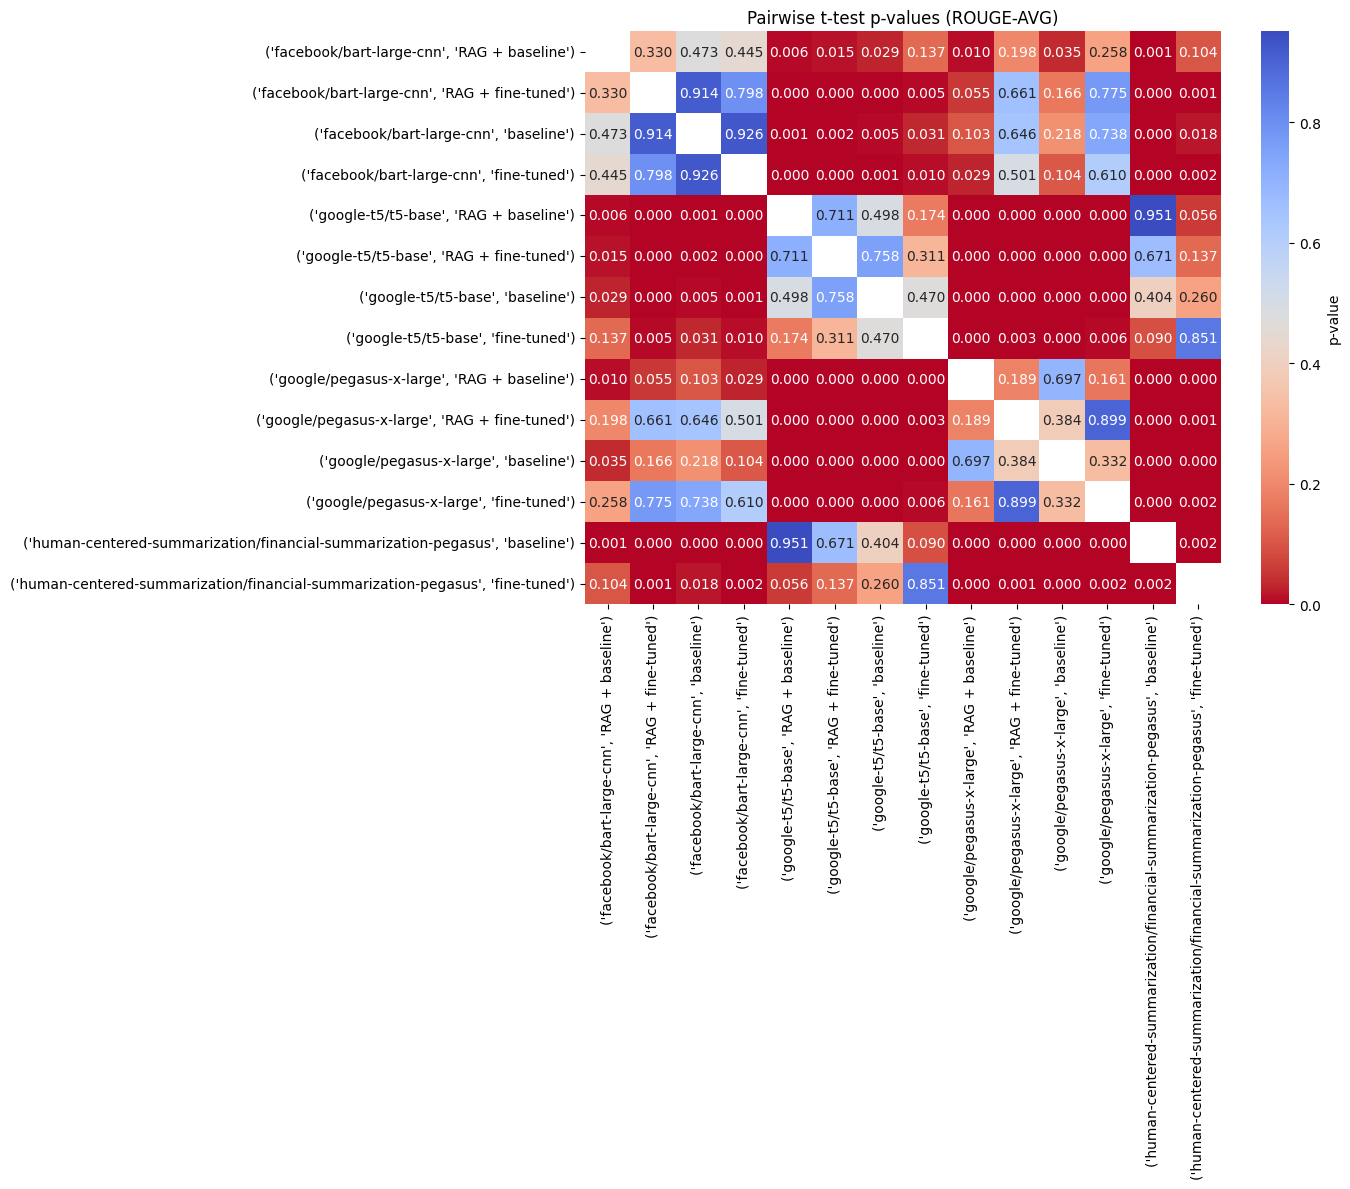

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Assume ttest_results is a list of dictionaries like you shared earlier
# Create labels
labels = sorted(set([r['group_1'] for r in ttest_results] + [r['group_2'] for r in ttest_results]))
label_to_index = {label: i for i, label in enumerate(labels)}
matrix_size = len(labels)
pval_matrix = np.full((matrix_size, matrix_size), np.nan)

# Fill matrix with p-values
for r in ttest_results:
    i, j = label_to_index[r['group_1']], label_to_index[r['group_2']]
    pval_matrix[i, j] = r['p_value']
    pval_matrix[j, i] = r['p_value']

# Convert to DataFrame
pval_df = pd.DataFrame(pval_matrix, index=labels, columns=labels)

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(pval_df, annot=True, fmt=".3f", cmap="coolwarm_r", cbar_kws={'label': 'p-value'})
plt.title("Pairwise t-test p-values (ROUGE-AVG)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

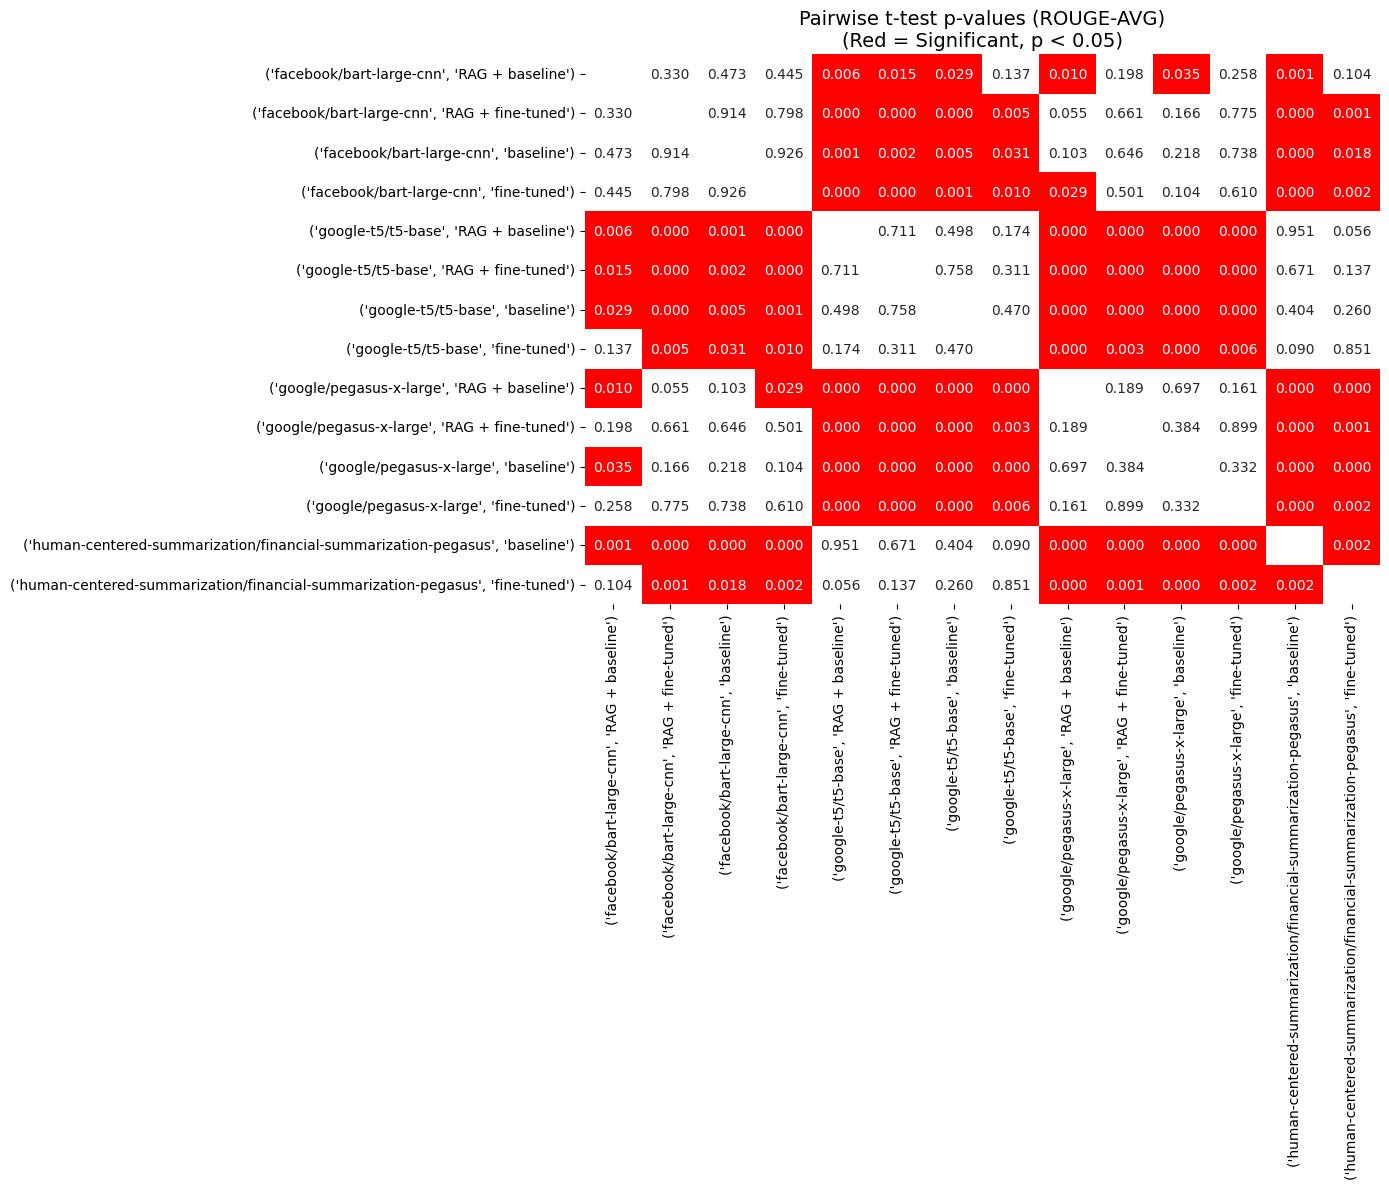

In [11]:
from matplotlib.colors import ListedColormap, BoundaryNorm

colors = ['red', 'white']
bounds = [0, 0.05, 1.01]  # upper bound slightly above 1 to catch all
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, ncolors=len(colors))

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(pval_df, annot=True, fmt=".3f", cmap=cmap, norm=norm, cbar=False)
plt.title("Pairwise t-test p-values (ROUGE-AVG)\n(Red = Significant, p < 0.05)", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

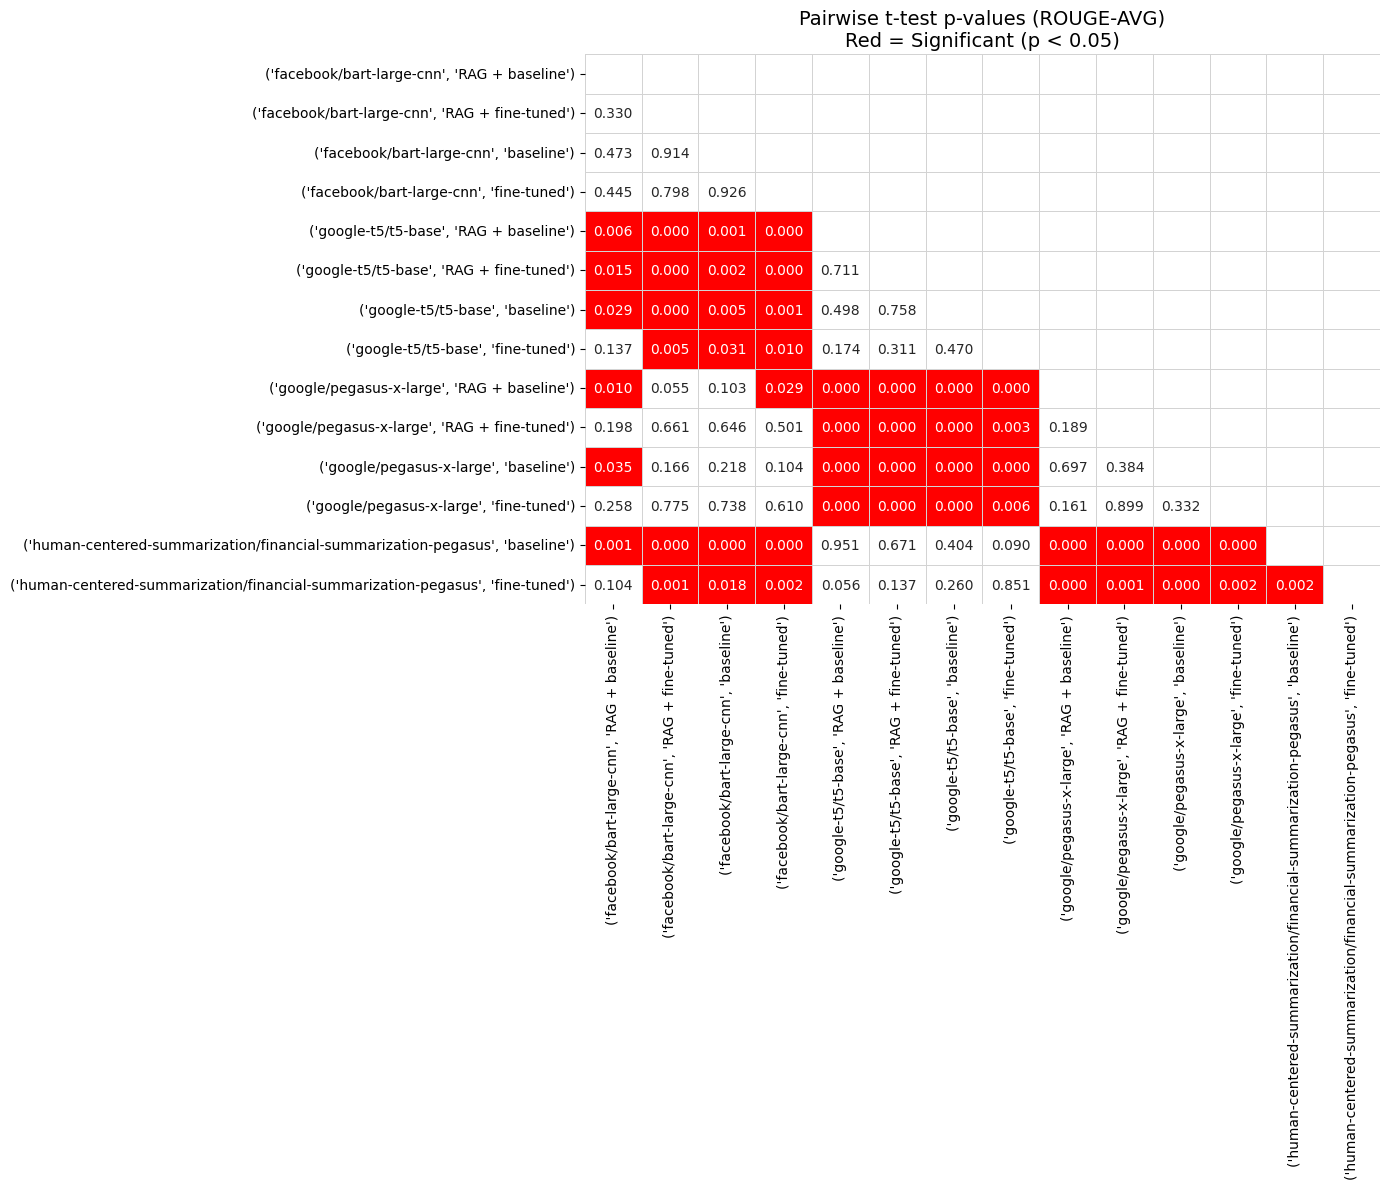

In [12]:
mask = np.triu(np.ones_like(pval_df, dtype=bool))

# Define custom colors: red for p < 0.05, white otherwise
colors = ['red', 'white']
bounds = [0, 0.05, 1.01]
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, ncolors=len(colors))

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(pval_df, mask=mask, annot=True, fmt=".3f", cmap=cmap, norm=norm, cbar=False,
            linewidths=0.5, linecolor='lightgray')
plt.title("Pairwise t-test p-values (ROUGE-AVG)\nRed = Significant (p < 0.05)", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [13]:
final_df['is_RAG'] = final_df['type'].str.contains('RAG', case=False)
final_df['is_finetuned'] = final_df['type'].str.contains('fine-tuned', case=False)

rag_scores = final_df[final_df['is_RAG']][metric]
non_rag_scores = final_df[~final_df['is_RAG']][metric]
rag_ttest = stats.ttest_ind(rag_scores, non_rag_scores, equal_var=False)

finetuned_scores = final_df[final_df['is_finetuned']][metric]
non_finetuned_scores = final_df[~final_df['is_finetuned']][metric]
finetuned_ttest = stats.ttest_ind(finetuned_scores, non_finetuned_scores, equal_var=False)

print("T-test: RAG vs Non-RAG")
print(f"T-statistic: {rag_ttest.statistic:.4f}, p-value: {rag_ttest.pvalue:.4e}")

print("\nT-test: Fine-tuned vs Non-Fine-tuned")
print(f"T-statistic: {finetuned_ttest.statistic:.4f}, p-value: {finetuned_ttest.pvalue:.4e}")


T-test: RAG vs Non-RAG
T-statistic: 0.8142, p-value: 4.1563e-01

T-test: Fine-tuned vs Non-Fine-tuned
T-statistic: 0.4172, p-value: 6.7658e-01


In [14]:
rouge_metrics = final_df[['rouge-1_f', 'rouge-2_f', 'rouge-l_f']]

correlation_matrix = rouge_metrics.corr(method='pearson')

spearman_corr = rouge_metrics.corr(method='spearman')
kendall_corr = rouge_metrics.corr(method='kendall')

correlation_matrix, spearman_corr, kendall_corr

(           rouge-1_f  rouge-2_f  rouge-l_f
 rouge-1_f   1.000000   0.973545   0.999798
 rouge-2_f   0.973545   1.000000   0.975575
 rouge-l_f   0.999798   0.975575   1.000000,
            rouge-1_f  rouge-2_f  rouge-l_f
 rouge-1_f   1.000000   0.948860   0.999389
 rouge-2_f   0.948860   1.000000   0.954711
 rouge-l_f   0.999389   0.954711   1.000000,
            rouge-1_f  rouge-2_f  rouge-l_f
 rouge-1_f   1.000000   0.821562   0.984039
 rouge-2_f   0.821562   1.000000   0.831565
 rouge-l_f   0.984039   0.831565   1.000000)

In [17]:
rouge_vs_word_count = final_df[['ROUGE-AVG', 'wor_count_nltk']]

correlation_matrix = rouge_vs_word_count.corr(method='pearson')

spearman_corr = rouge_vs_word_count.corr(method='spearman')
kendall_corr = rouge_vs_word_count.corr(method='kendall')

correlation_matrix, spearman_corr, kendall_corr

(                ROUGE-AVG  wor_count_nltk
 ROUGE-AVG        1.000000       -0.345698
 wor_count_nltk  -0.345698        1.000000,
                 ROUGE-AVG  wor_count_nltk
 ROUGE-AVG        1.000000       -0.352535
 wor_count_nltk  -0.352535        1.000000,
                 ROUGE-AVG  wor_count_nltk
 ROUGE-AVG        1.000000       -0.241769
 wor_count_nltk  -0.241769        1.000000)

In [18]:
final_df.columns

Index(['model_name', 'uuid', 'companyid', 'companyname', 'bleu',
       'bert_precision', 'bert_recall', 'bert_f1', 'meteor',
       'compression_ratio', 'readability', 'type', 'rouge-1_r', 'rouge-1_p',
       'rouge-1_f', 'rouge-2_r', 'rouge-2_p', 'rouge-2_f', 'rouge-l_r',
       'rouge-l_p', 'rouge-l_f', 'wor_count_nltk', 'summary',
       'evaluation_date', 'ROUGE-AVG', 'is_RAG', 'is_finetuned'],
      dtype='object')

In [21]:
rouge_vs_word_count = final_df[['bert_f1', 'meteor', 'bleu', 'wor_count_nltk']]

correlation_matrix = rouge_vs_word_count.corr(method='pearson')

spearman_corr = rouge_vs_word_count.corr(method='spearman')
kendall_corr = rouge_vs_word_count.corr(method='kendall')

correlation_matrix, spearman_corr, kendall_corr

(                 bert_f1    meteor      bleu  wor_count_nltk
 bert_f1         1.000000  0.394746  0.182977       -0.295216
 meteor          0.394746  1.000000  0.490823       -0.408903
 bleu            0.182977  0.490823  1.000000       -0.130085
 wor_count_nltk -0.295216 -0.408903 -0.130085        1.000000,
                  bert_f1    meteor      bleu  wor_count_nltk
 bert_f1         1.000000  0.303366  0.297362       -0.362558
 meteor          0.303366  1.000000  0.986171       -0.563774
 bleu            0.297362  0.986171  1.000000       -0.549769
 wor_count_nltk -0.362558 -0.563774 -0.549769        1.000000,
                  bert_f1    meteor      bleu  wor_count_nltk
 bert_f1         1.000000  0.205645  0.201333       -0.247283
 meteor          0.205645  1.000000  0.912355       -0.406209
 bleu            0.201333  0.912355  1.000000       -0.395017
 wor_count_nltk -0.247283 -0.406209 -0.395017        1.000000)

In [37]:
results = []
for model1, model2 in combinations(final_df['model_name'].unique(), 2):
    group1 = final_df[final_df['model_name'] == model1]['ROUGE-AVG'].dropna()
    group2 = final_df[final_df['model_name'] == model2]['ROUGE-AVG'].dropna()
    stat, p = stats.levene(group1, group2)
    results.append((model1, model2, stat, p))
    
results_df = pd.DataFrame(results)
results_df

,0,1,2,3
0,facebook/bart-large-cnn,google-t5/t5-base,1.312218,2.522014e-01
1,facebook/bart-large-cnn,google/pegasus-x-large,0.117669,7.316315e-01
2,facebook/bart-large-cnn,human-centered-summarization/financial-summari...,19.962137,8.811556e-06
3,google-t5/t5-base,google/pegasus-x-large,2.341516,1.262069e-01
4,google-t5/t5-base,human-centered-summarization/financial-summari...,35.792572,3.065579e-09
5,google/pegasus-x-large,human-centered-summarization/financial-summari...,18.615515,1.759840e-05
